In [334]:
from matplotlib import pyplot as plt
import numpy as np  
from scipy import ndimage

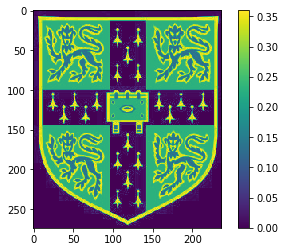

In [78]:
fpath = r'camb_shield.npy'
im = np.load(fpath)
im = np.max(im) - im
plt.imshow(im)
im.shape
plt.colorbar()

In [79]:
def rotate(im,a=0):
    return ndimage.rotate(im,a,order=1,reshape=False)

def project(im,a=0):
    if a != 0:
        imr = rotate(im,a)
    if a == 0:
        imr = im
    return np.sum(imr,axis=0)

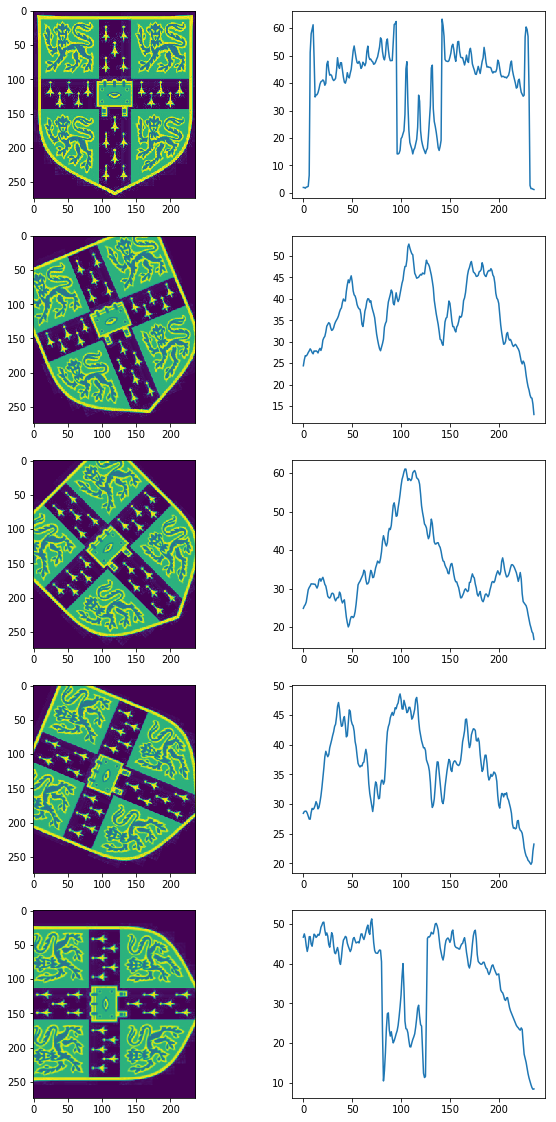

In [80]:
angles = np.linspace(0,90,num=5)

f,axs = plt.subplots(nrows=5,ncols=2,figsize=(10,20))
for i, a in enumerate(angles):
    imr = rotate(im,a=a)
    imp = project(imr)
    
    axs[i,0].imshow(imr)
    axs[i,1].plot(imp)

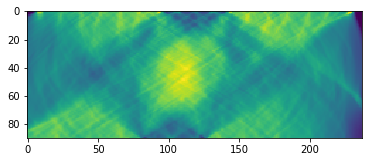

In [81]:
ps = []
for a in range(90):
    p = project(im,a)
    ps.append(p)
plt.imshow(ps)

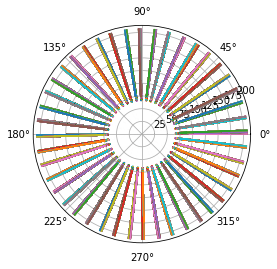

In [133]:
a = 0.0
p = project(im,a)
#plt.polar(np.ones_like(p)*a,p)
for a in range(90):
    plt.polar(np.ones_like(ps)*a,ps)
plt.show()

In [359]:
%matplotlib inline
# plt.figure(figsize=(5,5))
# plt.rcParams.update({'font.size': 12})
# ax = plt.gca()

d = 100
n = 100
lmin = 1
num = 20

def plot_slices(d=100,n=100,lmin=1,num=20, save_path = False,amax=90):
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 12})
    ax = plt.gca()

    im = np.ones((n,n))
    angles = np.linspace(-amax,amax,num=num)
    n = np.shape(im)[1]
    final = np.zeros((n,n))
    for a in angles:
        p = project(im,a)
        fs = np.zeros((n,n))
        centre = int(n/2)
        fs[centre,:] = p
        fsr = rotate(fs,a)
        final += fsr

    #pixel width real space
    px_im = d/n
    #pixel width in fourier space
    px_ft = 1/d #1/(n*px_im)
    # Total number of pixels needed for highest res
    N = 1/(lmin*px_ft)#1/(px_im*px_ft)
    # missing pixels in Fourier space
    missing = int((N-n)/2)
    # pad final image to get up to resolution
    if missing >= 0:
        extra = 0
        final = np.pad(final,[(missing, missing), (missing, missing)])
    if missing < 0:
        extra = int(abs(missing)/2)
        final = final[extra:-extra,extra:-extra]

    # set extent to max resoltuion
    res_max = lmin
    fres = 1/res_max
    extent = [-fres/2,fres/2,-fres/2,fres/2]

    #Crowther
    fmax = num/(np.pi * d)

    plt.imshow(final,vmax=1e-5,cmap='Greys_r',extent=extent)
    c = plt.Circle([0,0],radius=fmax,color='r',fill=False)
    ax.add_patch(c)
    plt.xlabel('k$_x$ / nm$^{-1}$')
    plt.ylabel('k$_y$ / nm$^{-1}$')
    plt.title('Size: %i nm x %i nm, Sampling: %i x %i, \n Pixel width: %.2f nm, %i projections' % (d,d,n,n,d/n,num))
    
    if save_path != False:
        plt.savefig(save_path)

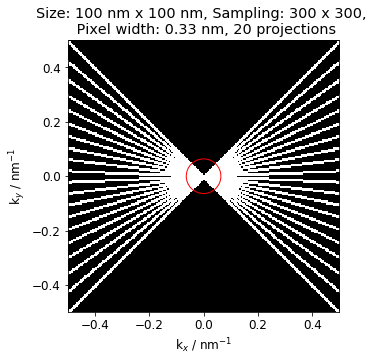

In [379]:
plot_slices(n=300,amax=45,num=20)

In [333]:
import imageio

#sizes = np.linspace(15,500,num=30)
#nums = np.linspace(1,100,num=30)
res = np.linspace(25,500,num=30)
fpaths = []
for x in res:
    x = int(x)
    fpath = r'Output_Data/slices/res/%i.png' % x
    plot_slices(n=x,save_path=fpath)
    fpaths.append(fpath)
    plt.close()
    
images = []
for f in fpaths:
    images.append(imageio.imread(f))
for f in fpaths[::-1]:
    images.append(imageio.imread(f))    
imageio.mimsave(r'Output_Data/slices/res.gif',images)

In [2]:
def sin_im(xFreq=10,yFreq=0,lims=[100,50],scales=[1,1]):
    """ Note that the frequency is relative to the size of the image
    i.e. xfreq 10 for an image 100 nm wide will peak at 0.1 nm^-1
    i.e. it will fit xfreq oscillations into lim space"""
    xFreq*=1/lims[0]#scales[0]
    yFreq*=1/lims[1]#scales[1]
    x = np.linspace(0, lims[0], int(lims[0]/scales[0]))
    y = np.linspace(0, lims[1], int(lims[1]/scales[1]))
    X,Y = np.meshgrid(x,y)
    im = np.exp(2j * np.pi * Y * yFreq) * np.exp(2j * np.pi * X * xFreq)
    return np.real(im)
    
def hamming_2d(im):
    s = np.shape(im)
    h1 = np.hamming(s[0])
    h2 = np.hamming(s[1])
    ham2d = (np.outer(h1,h2))
    return im*ham2d


# plt.show()

# f,axs = plt.subplots(nrows=3,ncols=3)
# for i in range(3):
#     for j in range(3):
#         axs[i,j].imshow(im)
#         axs[i,j].axis('off')
# #plt.tight_layout()
# plt.subplots_adjust(wspace=0.08, hspace=-0.5)

(-0.5, 99.5, 99.5, -0.5)

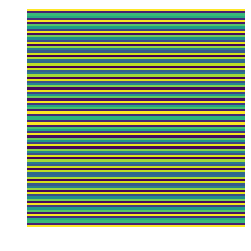

In [358]:
# im = np.ones((100,100))
# im = hamming_2d(im)
im = sin_im(xFreq=0,yFreq=0.4*100,lims=[100,100],scales=[1,1])
plt.imshow(im)
plt.axis('off')

In [335]:
def plot_FFT(im,scale=1,truncate=None,log=False,ax=None,ds=None,ns=None, lmin = None):
    """ Calculate and plot the FFt of an image
    To see fine details, try truncating the maximum value,
    plotting in log form, and scaling the data."""
    if ax==None:
        fig = plt.figure()
        ax = plt.gca()
    # https://stackoverflow.com/questions/39760962/how-to-normalise-a-2d-fft-plot-to-the-right-frequency-matlab
    F = np.fft.fft2(im)
    
    # A peculiarity of the DFT is that frequencies increase up to N/2
    # And then decrease from N/2 to N. This is a 'reflection' and is
    # to do with Nyquist sampling frequencies. We instead shift
    # such that the low frequencies are the in centre and we see a
    # range from -N/2 to N/2
    # We can do this because DFTs assume periodicity of the signal
    F_shift = np.fft.fftshift(F)
    
    # We want the amplitude spectrum which is the magnitude
    # we may also which to scale this to see more clearly
    F_shift_abs = abs(F_shift) * scale
    
    # showing on a log scale can show features more clearly
    if log == True:
        F_shift_abs = np.log(abs(F_shift)) * scale
    
    # truncating the maximum value can show more clearly
    if truncate == None:
        truncate = np.max(F_shift_abs)
        
    # establish spatial frequency axes
    
    # get image length d in nm and number of pixels n
    if ds == None:
        dy,dx = np.shape(im) # image length in nm
        nx,ny = dx,dy # number of samples along length
        
        ds,ns = [dx,dy], [nx,ny]
    dx,dy = ds
    nx,ny = ns  
    # get pixel width in real space in nm
    l_im_x = dx/nx
    l_im_y = dy/ny
    
    fx = 1/l_im_x * np.arange(-nx/2,nx/2-1)/nx
    fy = 1/l_im_y * np.arange(-ny/2,ny/2-1)/ny
    
    # get MINIMUM pixel width in real space in nm (at highst res)
    if lmin == None:
        lmin = [l_px_x,l_px_y]
        
    l_im_min_x,l_im_min_y = lmin
    
    # calculate pixel width in fourier space
    l_ft_x = 1/(l_im_x * nx) 
    l_ft_y = 1/(l_im_y * ny) 
    
    # calculate total number of pixels needed to reach highest resolution in FT
    Nx = 1/(l_im_min_x*l_ft_x)
    Ny = 1/(l_im_min_y*l_ft_y)
    
    # missing pixels
    missing_x = Nx - nx
    missing_y = Ny - ny
    
    fft = np.pad(F_shift_abs,[(int(missing_y/2), int(missing_y/2)), (int(missing_x/2), int(missing_x/2))])
    
    # left right bottom top
    #extent = [np.min(fx),np.max(fx),np.min(fy),np.max(fy)]
    #extent = [-1/l_im_x/2, 1/l_im_x/2, -1/l_im_y/2,1/l_im_y/2]
    extent = [-1/l_im_min_x/2,1/l_im_min_x/2,-1/l_im_min_x/2,1/l_im_min_x/2] 
    
    #print(l_ft_x,l_ft_y)
    imshow = ax.imshow(fft,vmax=truncate,cmap='Greys_r',extent=extent)
    plt.colorbar(imshow,fraction=0.046, pad=0.04)
    ax.set_title('Fourier space',fontsize=20)
    
    ax.set_xlabel('k$_x$ / nm$^{-1}$',fontsize=15)
    ax.set_ylabel('k$_y$ / nm$^{-1}$',fontsize=15)

In [181]:
%matplotlib
%matplotlib qt

Using matplotlib backend: Qt5Agg


Image dimensions: 287 x 84 nm 	 Image sampling: 212 x 76


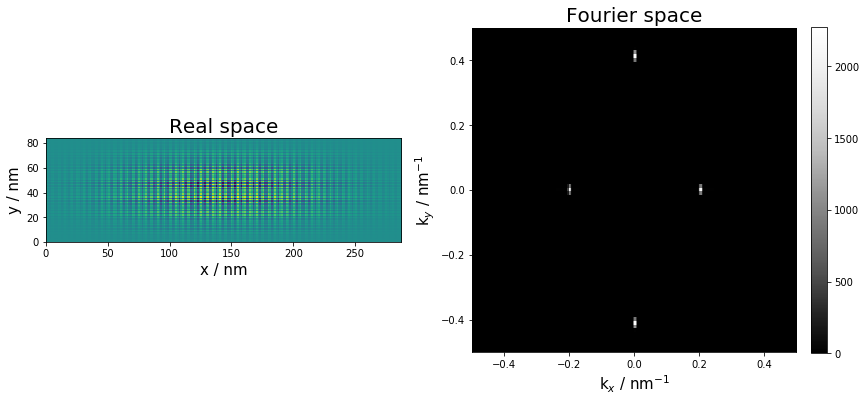

In [343]:
%matplotlib inline

# max sampling = minimum pixel length in nm
lmin = 1

# image lengths in nm
dx = 287
dy = 84

# image sampling no.s
nx = 212#dx/(lmin*1)
ny = 76#dy/(lmin*1)

# Create image
# Freq is f * d since Freq is the number of oscillations over the image
# so for a frequency of f, you need f*d oscillations per image 
im1 = sin_im(xFreq=.2*dx,yFreq=0*dy,lims=[dx,dy],scales=[dx/nx,dy/ny])
im2 = sin_im(xFreq=0*dx,yFreq=.4*dy,lims=[dx,dy],scales=[dx/nx,dy/ny])
im = im1+im2
im = hamming_2d(im)

# Plot image
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(14,7))
ly,lx = np.shape(im)
imshow1 = axs[0].imshow(im,extent=[0,dx,0,dy],cmap='viridis')
axs[0].set_title('Real space',fontsize=20)
axs[0].set_xlabel('x / nm',fontsize=15)
axs[0].set_ylabel('y / nm',fontsize=15)

# Plot FFT
plot_FFT(im,scale=1,truncate = None, log=False,ax=axs[1],ds=[dx,dy],ns=[nx,ny], lmin=[lmin,lmin])

print('Image dimensions:',dx,'x',dy,'nm \t Image sampling: %i x %i' %(nx,ny))